In [1]:
import time
import nrrd
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
import h5py

from dipy.tracking import eudx
from dipy.tracking.local import LocalTracking, ThresholdTissueClassifier
from dipy.tracking.utils import random_seeds_from_mask
from dipy.reconst.dti import TensorModel, quantize_evecs
from dipy.reconst.csdeconv import (ConstrainedSphericalDeconvModel,
                                   auto_response)
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model, DeterministicMaximumDirectionGetter
from dipy.data import fetch_stanford_hardi, read_stanford_hardi, get_sphere
from dipy.segment.mask import median_otsu
from dipy.viz import actor, window
from dipy.io.image import save_nifti
from dipy.io import read_bvals_bvecs
from dipy.core import gradients
from dipy.tracking.streamline import Streamlines, transform_streamlines
from dipy.tracking.utils import random_seeds_from_mask, seeds_from_mask
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table, gradient_table_from_bvals_bvecs
from dipy.reconst.dti import fractional_anisotropy
from dipy.tracking import utils

import src.dwi_tools as dwi_tools
import src.nn_helper as nn_helper

Using TensorFlow backend.


# ISMRM Processing

In [2]:
from dipy.segment.mask import median_otsu
pCaseID = 'ISMRM_2015_Tracto_challenge_data'
useDenoising = False
bvals,bvecs,gtab,dwi,aff,t1 = dwi_tools.loadISMRMData('data/%s' % (pCaseID), denoiseData = useDenoising, resliceToHCPDimensions=False)
b0_mask, binarymask = median_otsu(dwi[:,:,:,0], 2, 1)

Loading ismrm_denoised_preproc_mrtrix.nii.gz
(90, 108, 90, 33)


In [ ]:
from dipy.segment.mask import median_otsu
pCaseID = 'ISMRM_2015_Tracto_challenge_ground_truth_dwi_v2'
useDenoising = False
bvals,bvecs,gtab,dwi,aff,t1 = dwi_tools.loadISMRMDataArtifactFree('data/%s' % (pCaseID), denoiseData = useDenoising, resliceToHCPDimensions=False)
b0_mask, binarymask = median_otsu(dwi[:,:,:,0], 2, 1)

In [3]:
b_value = 1000

In [4]:
b0 = dwi[:,:,:,0]

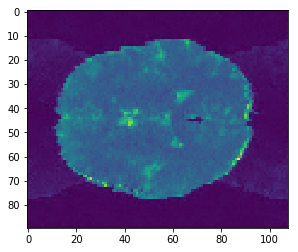

In [5]:
plt.imshow(b0[:,:,40])

In [ ]:
import dipy.reconst.dti as dti
start_time = time.time()
dti_model = dti.TensorModel(gtab)
dti_fit = dti_model.fit(dwi, mask=binarymask)
dti_fit_odf = dti_fit.odf(sphere = default_sphere)
dg = DeterministicMaximumDirectionGetter
dg = dg.from_pmf(dti_fit_odf, max_angle=30., sphere=default_sphere)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

In [8]:
wholebrainseeds = seeds_from_mask(binarymask, affine=aff)

In [ ]:
from dipy.tracking.local import BinaryTissueClassifier
classifier = ThresholdTissueClassifier(dti_fit.fa, .15)
streamline_generator_dti = LocalTracking(dg, classifier, wholebrainseeds, aff, step_size=0.6)
streamlines_dti = list(streamline_generator_dti)
streamlines_filtered_dti = dwi_tools.filterStreamlinesByLength(streamlines_dti, 40)

In [ ]:
dwi_tools.visStreamlines(streamlines_filtered_dti)

In [ ]:
dwi_tools.saveVTKstreamlines(streamlines_filtered_dti, 'ismrm_dti_fa015.vtk')

# rotate grid

In [ ]:
affine = aff
data = dwi

In [ ]:
aff_ras_ijk = np.linalg.inv(affine)
M = aff_ras_ijk[:3, :3]
abc = aff_ras_ijk[:3, 3]
abc = abc[:,None]

In [ ]:
slIdx = 0
slPos = 1
noX = 33
noY = 33
noZ = 33
coordinateScaling = 1

In [ ]:
import importlib
importlib.reload(dwi_tools)
x_,y_,z_ = dwi_tools._getCoordinateGrid(noX,noY,noZ,coordinateScaling)

In [ ]:
prevStreamlinePos_ras = streamlines_filtered_dti[0][slPos-1]
curStreamlinePos_ras = streamlines_filtered_dti[0][slPos]
curStreamlinePos_ras = curStreamlinePos_ras[:,None].T
curStreamlinePos_ijk = (M.dot(curStreamlinePos_ras.T) + abc).T
tangentCurStreamline_ras = prevStreamlinePos_ras - curStreamlinePos_ras

In [ ]:
selStreamline_ijk = transform_streamlines(streamlines_filtered_dti[10000:10001], np.linalg.inv(aff))
i=1

In [ ]:
i=50

In [ ]:
for i in range(1,100):
    prevStreamlinePos_ras = selStreamline_ijk[0][i-1].T
    curStreamlinePos_ras = selStreamline_ijk[0][i].T
    rotX = np.rad2deg( (np.dot(prevStreamlinePos_ras - curStreamlinePos_ras, np.array([[1,0,0]]).T)) / (np.linalg.norm(prevStreamlinePos_ras - curStreamlinePos_ras)))
    rotY = np.rad2deg( (np.dot(prevStreamlinePos_ras - curStreamlinePos_ras, np.array([[0,1,0]]).T)) / (np.linalg.norm(prevStreamlinePos_ras - curStreamlinePos_ras)))
    rotZ = np.rad2deg( (np.dot(prevStreamlinePos_ras - curStreamlinePos_ras, np.array([[0,0,1]]).T)) / (np.linalg.norm(prevStreamlinePos_ras - curStreamlinePos_ras)))
    print(str("%d: %.3f,%.3f,%.3f" % (i,rotX,rotY,rotZ)))

In [ ]:
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians. (Euler–Rodrigues formula)
    Parameters
        axis: rotation axis
        theta: radient
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(theta / 2.0)
    b, c, d = -axis * np.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

In [ ]:
def R_2vect(R, vector_orig, vector_fin):
    """Calculate the rotation matrix required to rotate from one vector to another.
    For the rotation of one vector to another, there are an infinit series of rotation matrices
    possible.  Due to axially symmetry, the rotation axis can be any vector lying in the symmetry
    plane between the two vectors.  Hence the axis-angle convention will be used to construct the
    matrix with the rotation axis defined as the cross product of the two vectors.  The rotation
    angle is the arccosine of the dot product of the two unit vectors.
    Given a unit vector parallel to the rotation axis, w = [x, y, z] and the rotation angle a,
    the rotation matrix R is::
              |  1 + (1-cos(a))*(x*x-1)   -z*sin(a)+(1-cos(a))*x*y   y*sin(a)+(1-cos(a))*x*z |
        R  =  |  z*sin(a)+(1-cos(a))*x*y   1 + (1-cos(a))*(y*y-1)   -x*sin(a)+(1-cos(a))*y*z |
              | -y*sin(a)+(1-cos(a))*x*z   x*sin(a)+(1-cos(a))*y*z   1 + (1-cos(a))*(z*z-1)  |
    @param R:           The 3x3 rotation matrix to update.
    @type R:            3x3 numpy array
    @param vector_orig: The unrotated vector defined in the reference frame.
    @type vector_orig:  numpy array, len 3
    @param vector_fin:  The rotated vector defined in the reference frame.
    @type vector_fin:   numpy array, len 3
    """

    # Convert the vectors to unit vectors.
    vector_orig = vector_orig / np.linalg.norm(vector_orig)
    vector_fin = vector_fin / np.linalg.norm(vector_fin)

    # The rotation axis (normalised).
    axis = np.cross(vector_orig, vector_fin)
    axis_len = np.linalg.norm(axis)
    if axis_len != 0.0:
        axis = axis / axis_len

    # Alias the axis coordinates.
    x = axis[0]
    y = axis[1]
    z = axis[2]

    # The rotation angle.
    angle = np.arccos(np.dot(vector_orig, vector_fin))

    # Trig functions (only need to do this maths once!).
    ca = np.cos(angle)
    sa = np.sin(angle)

    # Calculate the rotation matrix elements.
    R[0,0] = 1.0 + (1.0 - ca)*(x**2 - 1.0)
    R[0,1] = -z*sa + (1.0 - ca)*x*y
    R[0,2] = y*sa + (1.0 - ca)*x*z
    R[1,0] = z*sa+(1.0 - ca)*x*y
    R[1,1] = 1.0 + (1.0 - ca)*(y**2 - 1.0)
    R[1,2] = -x*sa+(1.0 - ca)*y*z
    R[2,0] = -y*sa+(1.0 - ca)*x*z
    R[2,1] = x*sa+(1.0 - ca)*y*z
    R[2,2] = 1.0 + (1.0 - ca)*(z**2 - 1.0)

In [ ]:
prevStreamlinePos_ras = selStreamline_ijk[0][i-1].T
curStreamlinePos_ras = np.dot(R,selStreamline_ijk[0][i].T - selStreamline_ijk[0][i-1].T) + selStreamline_ijk[0][i-1].T
rotX = np.rad2deg( (np.dot(prevStreamlinePos_ras - curStreamlinePos_ras, np.array([[1,0,0]]).T)) / (np.linalg.norm(prevStreamlinePos_ras - curStreamlinePos_ras)))
rotY = np.rad2deg( (np.dot(prevStreamlinePos_ras - curStreamlinePos_ras, np.array([[0,1,0]]).T)) / (np.linalg.norm(prevStreamlinePos_ras - curStreamlinePos_ras)))
rotZ = np.rad2deg( (np.dot(prevStreamlinePos_ras - curStreamlinePos_ras, np.array([[0,0,1]]).T)) / (np.linalg.norm(prevStreamlinePos_ras - curStreamlinePos_ras)))
print(str("%d: %.3f,%.3f,%.3f" % (i,rotX,rotY,rotZ)))
tangentCurStreamline_ras = (prevStreamlinePos_ras - curStreamlinePos_ras) 
tangentCurStreamline_ras /= np.linalg.norm(tangentCurStreamline_ras)
print(str(prevStreamlinePos_ras) + str(curStreamlinePos_ras))
tangentCurStreamline_ras

# rotate the whole grid

In [ ]:
import dipy.align.vector_fields as vfu
def interpolateRotatedDWIVolume(dwi, positions, rotations, x_,y_,z_, noX = 8, noY = 8, noZ = 8):
    szDWI = dwi.shape
    noPositions = len(positions)
    start_time = time.time()
    cvF = np.ones([noPositions*noX*noY*noZ,3])
    noElem = noX * noZ * noY
    grid = np.array(np.meshgrid(x_,y_,z_)).reshape(3,-1).T

    for j in range(0,noPositions):
        grid_rotated = grid
        if(rotations is not None):
            grid_rotated = rotateByMatrix(grid,rotations[j,])
        coordVecs = (grid_rotated + positions[j,:,None]).T
        il = j * noElem
        ir = (j+1) * noElem 
        cvF[il:ir] = coordVecs

    x = np.zeros([noPositions,noX,noY,noZ,szDWI[-1]])
    
    for i in range(0,szDWI[-1]):
        x[:,:,:,:,i] = np.reshape(vfu.interpolate_scalar_3d(dwi[:,:,:,i],cvF)[0], [noPositions,noX,noY,noZ])
        
    return x

In [ ]:
np.array(np.meshgrid(x_,y_,z_)).reshape(3,-1).shape

In [ ]:
def rotateByMatrix(vectorsToRotate,rotationMatrix,rotationCenterVector = np.array([0,0,0])):\
    return np.dot(rotationMatrix,vectorsToRotate.T - rotationCenterVector[:,None]) + rotationCenterVector[:,None]

In [ ]:
np.dot(R,[0,0,0])

In [ ]:
dwi_interp = interpolateDWIVolume(dwi, np.array([curStreamlinePos_ras]), noX = noX, noY = noY, noZ = noZ,x_ = x_,y_ = y_,z_ = z_)
plt.imshow(dwi_interp[0,:,:,0,0])
dwi_interp[0,17,17,17,0]

In [ ]:
c = np.eye(3)
prevStreamlinePos_ras = selStreamline_ijk[0][i-1].T
curStreamlinePos_ras = selStreamline_ijk[0][i].T
rotX = np.rad2deg( (np.dot(prevStreamlinePos_ras - curStreamlinePos_ras, np.array([[1,0,0]]).T)) / (np.linalg.norm(prevStreamlinePos_ras - curStreamlinePos_ras)))
rotY = np.rad2deg( (np.dot(prevStreamlinePos_ras - curStreamlinePos_ras, np.array([[0,1,0]]).T)) / (np.linalg.norm(prevStreamlinePos_ras - curStreamlinePos_ras)))
rotZ = np.rad2deg( (np.dot(prevStreamlinePos_ras - curStreamlinePos_ras, np.array([[0,0,1]]).T)) / (np.linalg.norm(prevStreamlinePos_ras - curStreamlinePos_ras)))
print(str("%d: %.3f,%.3f,%.3f" % (i,rotX,rotY,rotZ)))
tangentCurStreamline_ras = (prevStreamlinePos_ras - curStreamlinePos_ras)
tangentCurStreamline_ras /= np.linalg.norm(tangentCurStreamline_ras)
print(str(prevStreamlinePos_ras) + str(curStreamlinePos_ras))
tangentCurStreamline_ras
R2 = np.eye(3)
R_2vect(R2,vector_orig=tangentCurStreamline_ras,vector_fin=vv)

In [ ]:
dwi_interp = interpolateRotatedDWIVolume(dwi, np.array([curStreamlinePos_ras,curStreamlinePos_ras]), noX = noX, noY = noY, noZ = noZ,x_ = x_,y_ = y_,z_ = z_, rotations = np.array([R2,R2]))
plt.imshow(dwi_interp[0,:,:,0,0])
dwi_interp[0,17,17,17,0]

In [ ]:
i

In [ ]:
tangents = selStreamline_ijk[0][0:-1] - selStreamline_ijk[0][1:]

In [ ]:
noPoints = 60

In [ ]:
vv = [0,1,0]

In [ ]:
rot = np.zeros([noPoints,3,3])
rot[0,:] = np.eye(3)
for k in range(noPoints-1):
    R_2vect(rot[k+1,:],vector_orig=tangents[k,],vector_fin=vv)

In [ ]:
rot[i,]

In [ ]:
R2

In [ ]:
R = 2 * np.outer( (tangentCurStreamline_ras + vv), (tangentCurStreamline_ras + vv) ) / np.inner( (tangentCurStreamline_ras + vv), (tangentCurStreamline_ras + vv) ) - np.eye(3)

In [ ]:
R

# CSD

In [6]:
response, ratio = auto_response(gtab, dwi, roi_radius=10, fa_thr=0.7)
csd_model = ConstrainedSphericalDeconvModel(gtab, response)
sphere = get_sphere('symmetric724')
start_time = time.time()
csd_peaks = peaks_from_model(model=csd_model,
                             data=dwi,
                             sphere=sphere,
                             mask=binarymask,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=False)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s')
import dipy.reconst.dti as dti
start_time = time.time()
dti_model = dti.TensorModel(gtab, fit_method='LS')
dti_fit = dti_model.fit(dwi, mask=binarymask)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

/home/nico/anaconda3/lib/python3.6/site-packages/dipy/reconst/csdeconv.py:130: UserWarning: Number of parameters required for the fit are more than the actual data points
  warnings.warn(msg, UserWarning)


Runtime 692.4177923202515 s
Runtime 2.3059170246124268s


In [11]:
start_time = time.time()
classifier = ThresholdTissueClassifier(dti_fit.fa, .15)
streamlines_generator = LocalTracking(csd_peaks, classifier, wholebrainseeds, aff, step_size=1.0)
streamlines = Streamlines(streamlines_generator)
streamlines_filtered = dwi_tools.filterStreamlinesByLength(streamlines, 20)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

Runtime 21.091662645339966s


In [12]:
dwi_tools.visStreamlines(streamlines_filtered)

Lsl:64457


/home/nico/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [13]:
dwi_tools.saveVTKstreamlines(streamlines_filtered, 'ismrm_csd_fa015_20mm_noreslicing_mrtrixDenoised.vtk')

0/64457
10000/64457
20000/64457
30000/64457
40000/64457
50000/64457
60000/64457
64456/64457
Wrote streamlines to ismrm_csd_fa015_20mm_noreslicing_mrtrixDenoised.vtk


In [ ]:
sl2 = dwi_tools.filterStreamlinesByCurvature(streamlines_filtered, 20)

In [ ]:
b_value = 1000

In [ ]:
# crop DWI data
dwi_subset, gtab_subset, bvals_subset, bvecs_subset = dwi_tools.cropDatsetToBValue(b_value, bvals, bvecs, dwi)
b0_idx = bvals < 10
b0 = dwi[..., b0_idx].mean(axis=3)
dwi_singleShell = np.concatenate((dwi_subset, dwi[..., b0_idx]), axis=3)
#    dwi_singleShell_norm = dwi_tools.normalize_dwi(dwi_singleShell, b0)
bvals_singleShell = np.concatenate((bvals_subset, bvals[..., b0_idx]), axis=0)
bvecs_singleShell = np.concatenate((bvecs_subset, bvecs[b0_idx,]), axis=0)
gtab_singleShell = gradient_table(bvals=bvals_singleShell, bvecs=bvecs_singleShell, b0_threshold = 10)

In [ ]:
streamlines_filtered = dwi_tools.loadVTKstreamlines('data/ismrm_csd_fa015.vtk')

In [ ]:
streamlines_ismrm_curated = dwi_tools.loadVTKstreamlines('data/ismrm_csd_fa015_curated_without_fp.vtk')

In [ ]:
sl_r = np.random.choice(streamlines_filtered,30000, replace=False)

In [ ]:
trackingMethod = 'csd_ismrm_gt_aggrPast'

In [ ]:
noX = 1
noY = 1
noZ = 1
coordinateScaling = 1
noCrossingFibres = 3
sh_order = 8
step_size = 0.6
b_value = 1000
unitTension = False

In [ ]:
data_sh = dwi_tools.get_spherical_harmonics_coefficients(bvals=bvals_subset,bvecs=bvecs_subset,sh_order=sh_order, dwi=dwi_subset, b0 = b0)

In [ ]:
dwi_subset_100, resamplingSphere = dwi_tools.resample_dwi(dwi_subset, b0, bvals_subset, bvecs_subset, sh_order=8, smooth=0, mean_centering=False)

In [ ]:
import importlib
importlib.reload(dwi_tools)
start_time = time.time()
train_DWI,train_prevDirection, train_nextDirection,_,slo,train_DWI_pastAggregated = dwi_tools.generateTrainingData(sl_r, dwi_subset_100, unitTension = unitTension, affine=aff, noX=noX,noY=noY,noZ=noZ,coordinateScaling=coordinateScaling,distToNeighbours=1, noCrossings = noCrossingFibres, step = 1)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

In [ ]:
pTrainData = 'data/train_res100_30k_noB0InSH_step%.1f_wholeBrain_b%d_%s_%dx%dx%d_noUnitTension.h5' % (step_size,b_value,trackingMethod,noX,noY,noZ)
pTrainData

In [ ]:
#pTrainData = 'data/train_res100_30k_noB0InSH_step%.1f_wholeBrain_b%d_%s_%dx%dx%d_noUnitTension.h5' % (step_size,b_value,trackingMethod,noX,noY,noZ)
with h5py.File(pTrainData,"w") as f:
    f.create_dataset('train_DWI',data=train_DWI)
    f.create_dataset('train_DWI_pastAgg',data=train_DWI_pastAggregated)
    f.create_dataset('train_curPosition',data=train_prevDirection)   
#   f.create_dataset('train_LikelyFibreDirections',data=train_LikelyFibreDirections)   
    f.create_dataset('train_NextFibreDirection',data=train_nextDirection)

In [ ]:
pTrainData

In [ ]:
del train_DWI

In [ ]:
start_time = time.time()
train_DWI,train_prevDirection, train_nextDirection,_ = dwi_tools.generateTrainingData_fstr(streamlines_ismrm_curated, dwi_subset_100, unitTension = unitTension, affine=aff, noX=noX,noY=noY,noZ=noZ,coordinateScaling=coordinateScaling,distToNeighbours=1, noCrossings = noCrossingFibres, step = 1)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

In [ ]:
#pTrainData = 'data/train_res100_30k_noB0InSH_step%.1f_wholeBrain_b%d_%s_%dx%dx%d_noUnitTension.h5' % (step_size,b_value,trackingMethod,noX,noY,noZ)
pTrainData = 'data/train_res100_all_noB0InSH_step%.1f_wholeBrain_b%d_%s_%dx%dx%d_noUnitTension.h5' % (step_size,b_value,trackingMethod,noX,noY,noZ)
with h5py.File(pTrainData,"w") as f:
    f.create_dataset('train_DWI',data=train_DWI)
    f.create_dataset('train_curPosition',data=train_prevDirection)   
#   f.create_dataset('train_LikelyFibreDirections',data=train_LikelyFibreDirections)   
    f.create_dataset('train_NextFibreDirection',data=train_nextDirection)

In [ ]:
dwi_subset, gtab_subset, bvals_subset, bvecs_subset = dwi_tools.cropDatsetToBValue(b_value, bvals, bvecs, dwi)

In [ ]:
tracking_data, resamplingSphere = dwi_tools.resample_dwi_forunet(dwi_subset, b0, bvals_subset, bvecs_subset, sh_order=8, smooth=0, mean_centering=False)

In [ ]:
trackingMethod = 'csd_ismrm_groundtruth_aggrPast'

In [ ]:
import importlib
importlib.reload(dwi_tools)

In [ ]:
start_time = time.time()
train_DWI_fstr,train_prevDirection_fstr, train_nextDirection_fstr, train_DWI_past_fstr = dwi_tools.generateTrainingData_fstr(sl_r, np.array(tracking_data, dtype=np.float), unitTension = unitTension, affine=aff, noX=noX,noY=noY,noZ=noZ,coordinateScaling=coordinateScaling,distToNeighbours=1, noCrossings = noCrossingFibres, step = 1)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

In [ ]:
pTrainData = 'data/train_res1002D_16x16_prevDWI_30k_noB0InSH_step%.1f_wholeBrain_b%d_%s_%dx%dx%d_noUnitTension.h5' % (step_size,b_value,trackingMethod,noX,noY,noZ)
with h5py.File(pTrainData,"w") as f:
    f.create_dataset('train_DWI',data=train_DWI_fstr)
    f.create_dataset('train_DWI_prev',data=train_DWI_past_fstr)
    f.create_dataset('train_curPosition',data=train_prevDirection_fstr)   
#   f.create_dataset('train_LikelyFibreDirections',data=train_LikelyFibreDirections)   
    f.create_dataset('train_NextFibreDirection',data=train_nextDirection_fstr)

In [ ]:
pTrainData

In [ ]:
train_DWI_past_fstr.shape

In [ ]:
train_DWI_fstr[1000,0,0,0,10]

In [ ]:
train_DWI_past_fstr[1000+1,0,0,0,10]

In [ ]:
vv = np.stack((train_DWI_fstr, train_DWI_past_fstr))
vv = np.moveaxis(vv,0,-1)

In [ ]:
vv.shape

In [ ]:
pTrainData

In [ ]:
train_DWI_fstr.shape

In [ ]:
streamlineIndex = 0

# Preprocessing

crop multi-shell DWI to single shell data

In [25]:
b_value = 1000
sh_order = 8
bvals,bvecs,gtab,dwi,aff,t1,binarymask = dwi_tools.loadHCPData('data/HCP/100307')
dwi_subset, gtab_subset, bvals_subset, bvecs_subset = dwi_tools.cropDatsetToBValue(b_value, bvals, bvecs, dwi)

The average b0 image is required for data normalization.

In [26]:
b0_idx = bvals < 10
b0 = dwi[..., b0_idx].mean(axis=3)

In [27]:
dwi_singleShell_withb0 = np.concatenate((dwi_subset, dwi[..., b0_idx]), axis=3)
bvals_singleShell_withb0 = np.concatenate((bvals_subset, bvals[..., b0_idx]), axis=0)
bvecs_singleShell_withb0 = np.concatenate((bvecs_subset, bvecs[b0_idx,]), axis=0)
gtab_singleShell_withb0 = gradient_table(bvals=bvals_singleShell_withb0, bvecs=bvecs_singleShell_withb0, b0_threshold = 10)

In [28]:
dwi_subset_ressampled, resamplingSphere = dwi_tools.resample_dwi(dwi_subset, b0, bvals_subset, bvecs_subset, sh_order=8, smooth=0, mean_centering=False)

Percentage erroneous voxels: 1.68


/home/nico/Code/deepFibreTracking/src/dwi_tools.py:286: RuntimeWarning: divide by zero encountered in true_divide
  weights_normed = (weights / b0)
/home/nico/Code/deepFibreTracking/src/dwi_tools.py:286: RuntimeWarning: invalid value encountered in true_divide
  weights_normed = (weights / b0)


# Tractography

In this section we'll generate streamlines using different approaches. This is gonna be the foundation for the evaluation of our method. We'll also employ simulated as well as curated data for our analysis.

In [ ]:
step_size = 0.6 # mm

In [ ]:
# roi_idx = (slice(20, 50), slice(55, 85), slice(38, 39)) #  splenium of the corpus callosum
ccmask, options = nrrd.read('data/HCP/100307/100307-ccSegmentation.nrrd')
ccseeds = seeds_from_mask(ccmask, affine=aff)
wholebrainseeds = seeds_from_mask(binarymask, affine=aff)
validationSeeds = ccseeds[45:48]
rndseeds = random_seeds_from_mask(binarymask, seeds_count=4000, seed_count_per_voxel=False, affine=aff)

## Single Tensor Model

In [ ]:
import dipy.reconst.dti as dti
start_time = time.time()
dti_model = dti.TensorModel(gtab_subset)
dti_fit = dti_model.fit(dwi_subset, mask=binarymask)
dti_fit_odf = dti_fit.odf(sphere = default_sphere)
dg = DeterministicMaximumDirectionGetter
dg = dg.from_pmf(dti_fit_odf, max_angle=30., sphere=default_sphere)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

---
STM using spherical harmonics

In [ ]:
from dipy.data import default_sphere
from dipy.direction import DeterministicMaximumDirectionGetter

start_time = time.time()

csd_model = ConstrainedSphericalDeconvModel(gtab_singleShell, None, sh_order=sh_order)
csd_fit = csd_model.fit(dwi_singleShell_norm, mask=binarymask)


dg = DeterministicMaximumDirectionGetter.from_shcoeff(csd_fit.shm_coeff,
                                                             max_angle=30.,
                                                             sphere=default_sphere)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

---
track streamlines

In [ ]:
from dipy.tracking.local import BinaryTissueClassifier
classifier = ThresholdTissueClassifier(dti_fit.fa, .15)
streamline_generator_dti = LocalTracking(dg, classifier, wholebrainseeds, aff, step_size=step_size)
streamlines_dti = list(streamline_generator_dti)
streamlines_filtered_dti = dwi_tools.filterStreamlinesByLength(streamlines_dti, 40)

In [ ]:
dwi_tools.visStreamlines(streamlines_filtered_dti)

In [ ]:
import importlib
importlib.reload(dwi_tools)
import src.dwi_tools as dwi_tools
from dipy.tracking.streamline import transform_streamlines
streamlines_imageCS = transform_streamlines(sl_r,np.linalg.inv(aff)) # project streamlines from RAS into image (voxel) coordinate system

---
---
## Q-ball Reconstruction
---
---

In [ ]:
csamodel = CsaOdfModel(gtab, 4)
sphere = get_sphere('symmetric724')
start_time = time.time()
csapeaks = peaks_from_model(model=csamodel,
                            data=dwi,
                            sphere=sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            mask=binarymask,
                            return_odf=False,
                            parallel=True,
                            normalize_peaks=False)

GFA = csapeaks.gfa
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s / GFA.shape (%d, %d, %d)' % GFA.shape)

tracking

In [ ]:
classifier = ThresholdTissueClassifier(dtipeaks.gfa, .25)
streamlines_generator = LocalTracking(csapeaks, classifier, seeds, np.identity(4), step_size=.5)
streamlines = Streamlines(streamlines_generator)
streamlines_filtered = dwi_tools.filterStreamlinesByLength(streamlines, 50)

---
---
## Constrained Spherical Deconvolution
---
---

Use in case of b = 2,500 – 3,000 s/mm² data

In [ ]:
response, ratio = auto_response(gtab_singleShell_withb0, dwi_singleShell_withb0, roi_radius=10, fa_thr=0.7)
csd_model = ConstrainedSphericalDeconvModel(gtab_singleShell_withb0, response)
sphere = get_sphere('symmetric724')

In [ ]:
start_time = time.time()
csd_peaks = peaks_from_model(model=csd_model,
                             data=dwi_singleShell_withb0,
                             sphere=sphere,
                             mask=binarymask,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=False)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s')

In [ ]:
import dipy.reconst.dti as dti
start_time = time.time()
dti_model = dti.TensorModel(gtab_singleShell_withb0, fit_method='LS')
dti_fit = dti_model.fit(dwi_singleShell_withb0, mask=binarymask)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

In [ ]:
start_time = time.time()
classifier = ThresholdTissueClassifier(dti_fit.fa, .2)
streamlines_generator = LocalTracking(csd_peaks, classifier, wholebrainseeds, aff, step_size=step_size)
streamlines = Streamlines(streamlines_generator)
streamlines_filtered = dwi_tools.filterStreamlinesByLength(streamlines, 50)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

In [ ]:
step_size

In [ ]:
dwi_tools.visStreamlines(streamlines_filtered)

In [ ]:
pBaselineStreamlines = 'data/train_step%.1f_wholeBrain_b%d_2_csd_peaks.vtk' % (step_size,b_value)
dwi_tools.saveVTKstreamlines(streamlines_filtered,pBaselineStreamlines)

In [ ]:
start_time = time.time()
csd_fit = csd_model.fit(dwi_singleShell_withb0, mask=binarymask)
dg = DeterministicMaximumDirectionGetter.from_shcoeff(csd_fit.shm_coeff,
                                                      max_angle=30.,
                                                      sphere=sphere)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

In [ ]:
start_time = time.time()
classifier = ThresholdTissueClassifier(dti_fit.fa, .2)
streamlines_generator = LocalTracking(dg, classifier, wholebrainseeds, aff, step_size=step_size)
streamlines_dg = Streamlines(streamlines_generator)
streamlines_filtered_dg = dwi_tools.filterStreamlinesByLength(streamlines_dg, 50)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

In [ ]:
pBaselineStreamlines = 'data/train_step%.1f_wholeBrain_b%d_csd_deterministic.vtk' % (step_size,b_value)
dwi_tools.saveVTKstreamlines(streamlines_filtered_dg,pBaselineStreamlines)

# Generate Training data

In [ ]:
sl_r = np.random.choice(streamlines_filtered,30000, replace=False)

### old fashioned

In [ ]:
trackingMethod = 'csd_ismrm'
#sl_r = streamlines_ukf_curated
#trackingMethod = 'ukf_curated'
#sl_r = streamlines_csd_peaks_curated
#trackingMethod = 'csd_curated'

In [ ]:
data_sh = dwi_tools.get_spherical_harmonics_coefficients(bvals=bvals,bvecs=bvecs,sh_order=sh_order, dwi=dwi, b0 = b0)

In [ ]:
noX = 1
noY = 1
noZ = 1
coordinateScaling = 1
noCrossingFibres = 3
sh_order = 8

In [ ]:
importlib.reload(dwi_tools)
data_sh = dwi_tools.get_spherical_harmonics_coefficients(bvals=bvals_subset,bvecs=bvecs_subset,sh_order=sh_order, dwi=dwi_subset, b0 = b0)

In [ ]:
import importlib
importlib.reload(dwi_tools) 
import src.dwi_tools as dwi_tools

#rawData = dwi_singleShell_norm
#rawData = dtiPeakDirs
#rawData = dti_fit.quadratic_form.reshape([145,174,145,9])
#rawData = dti_fit_odf
#rawData = csd_fit.shm_coeff # spherical harmonics
#rawData = dwi_tools.get_spherical_harmonics_coefficients(bvals=bvals_singleShell,bvecs=bvecs_singleShell,sh_order=sh_order, dwi=dwi_singleShell_norm, b0 = 0)
#rawData = dwi_subset_ressampled
rawData = data_sh

start_time = time.time()
train_DWI,train_prevDirection, train_nextDirection = dwi_tools.generateTrainingData(sl_r, rawData, unitTension = True, affine=aff, noX=noX,noY=noY,noZ=noZ,coordinateScaling=coordinateScaling,distToNeighbours=1, noCrossings = noCrossingFibres, step = 1)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

In [ ]:
pTrainData = 'data/train_sh%d_noB0InSH_step%.1f_wholeBrain_b%d_2_%s_%dx%dx%d.h5' % (sh_order,step_size,b_value,trackingMethod,noX,noY,noZ)
with h5py.File(pTrainData,"w") as f:
    f.create_dataset('train_DWI',data=train_DWI)
    f.create_dataset('train_curPosition',data=train_prevDirection)   
#   f.create_dataset('train_LikelyFibreDirections',data=train_LikelyFibreDirections)   
    f.create_dataset('train_NextFibreDirection',data=train_nextDirection)

In [ ]:
pTrainData

In [ ]:
dwi_tools.saveVTKstreamlines(sl_r,pBaselineStreamlines)

### 2D projection of DWI coefficients

In [ ]:
importlib.reload(dwi_tools)
dwi_subset_ressampled, resamplingSphere = dwi_tools.resample_dwi_forunet(dwi_subset, b0, bvals_subset, bvecs_subset, sh_order=8, smooth=0, mean_centering=False)
raw_data = dwi_subset_ressampled

start_time = time.time()
train_DWI,train_prevDirection, train_nextDirection = dwi_tools.generate2DUnrolledTrainingData(sl_r, raw_data, resamplingSphere = resamplingSphere, affine=aff, coordinateScaling=coordinateScaling,distToNeighbours=1, noCrossings = noCrossingFibres, step = 1)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

In [ ]:
pTrainData = 'data/train_resampled_10x10_noB0InSH_step%.1f_wholeBrain_b%d_2_%s.h5' % (step_size,b_value,trackingMethod)
pTrainData

In [ ]:
with h5py.File(pTrainData,"w") as f:
    f.create_dataset('train_DWI',data=train_DWI)
    f.create_dataset('train_curPosition',data=train_prevDirection)   
#   f.create_dataset('train_LikelyFibreDirections',data=train_LikelyFibreDirections)   
    f.create_dataset('train_NextFibreDirection',data=train_nextDirection)   

# Generate data from UKF streamlines

In [ ]:
streamlines = dwi_tools.loadVTKstreamlines('data/HCP/ukf_103818_b1000.vtk')

In [30]:
streamlines_imageCS = transform_streamlines(streamlines_curated,np.linalg.inv(aff)) # project streamlines from RAS into image (voxel) coordinate system
dwi_tools.visStreamlines(streamlines_imageCS, dwi_subset[:,:,:,0])

Lsl:26336


/home/nico/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [31]:
sl_r = np.random.choice(streamlines_curated,3000, replace=False)

In [ ]:
b_value = 1000
sh_order = 8
bvals,bvecs,gtab,dwi,aff,t1,binarymask = dwi_tools.loadHCPData('data/HCP/100307')
dwi_subset, gtab_subset, bvals_subset, bvecs_subset = dwi_tools.cropDatsetToBValue(b_value, bvals, bvecs, dwi)

# crop DWI data
b0_idx = bvals < 10
b0 = dwi[..., b0_idx].mean(axis=3)

dwi_singleShell_withb0 = np.concatenate((dwi_subset, dwi[..., b0_idx]), axis=3)
bvals_singleShell_withb0 = np.concatenate((bvals_subset, bvals[..., b0_idx]), axis=0)
bvecs_singleShell_withb0 = np.concatenate((bvecs_subset, bvecs[b0_idx,]), axis=0)
gtab_singleShell_withb0 = gradient_table(bvals=bvals_singleShell_withb0, bvecs=bvecs_singleShell_withb0, b0_threshold = 10)

In [ ]:
wholebrainseeds = seeds_from_mask(binarymask, affine=aff)

In [ ]:
data_sh = dwi_tools.get_spherical_harmonics_coefficients(bvals=bvals_subset,bvecs=bvecs_subset,sh_order=sh_order, dwi=dwi_subset, b0 = b0)

In [45]:
noX = 3
noY = 3
noZ = 3
coordinateScaling = 1
noCrossingFibres = 1

import importlib
importlib.reload(dwi_tools) 
import src.dwi_tools as dwi_tools

start_time = time.time()
interpolatedDWISubvolume, directionToPreviousStreamlinePoint, directionToNextStreamlinePoint, interpolatedDWISubvolumePast = dwi_tools.generateTrainingData(sl_r, dwi_subset_ressampled, unitTension = False, affine=aff, noX=noX,noY=noY,noZ=noZ,coordinateScaling=coordinateScaling,distToNeighbours=1, noCrossings = noCrossingFibres, step = 1)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

Runtime 148.32198524475098 s 


In [46]:
import importlib
importlib.reload(dwi_tools) 
import src.dwi_tools as dwi_tools

start_time = time.time()
interpolatedDWISubvolume2, directionToPreviousStreamlinePoint2, directionToNextStreamlinePoint2, interpolatedDWISubvolumePast2 = dwi_tools.generateTrainingData(sl_r, dwi_subset_ressampled, unitTension = False, affine=aff, noX=noX,noY=noY,noZ=noZ,coordinateScaling=coordinateScaling,distToNeighbours=1, noCrossings = noCrossingFibres, step = 1, generateRandomData = True)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

Runtime 138.56333374977112 s 


In [59]:
np.concatenate((directionToPreviousStreamlinePoint,directionToPreviousStreamlinePoint2)).shape

(619438, 3)

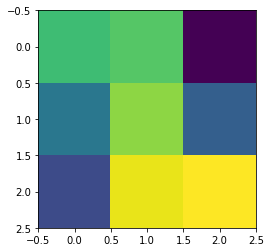

In [56]:
plt.imshow(interpolatedDWISubvolume[99,:,:,2,9])

In [35]:
trackingMethod = 'ukf_b1000real'

In [ ]:
pTrainData = 'data/train_sh%d_noB0InSH_step%.1f_wholeBrain_b%d_2_%s_%dx%dx%d.h5' % (sh_order,step_size,b_value,trackingMethod,noX,noY,noZ)
with h5py.File(pTrainData,"w") as f:
    f.create_dataset('train_DWI',data=train_DWI)
    f.create_dataset('train_curPosition',data=train_prevDirection)   
#   f.create_dataset('train_LikelyFibreDirections',data=train_LikelyFibreDirections)   
    f.create_dataset('train_NextFibreDirection',data=train_nextDirection)

# Create curated dataset

In [15]:
import os
import src.wma_interactor as wma

In [ ]:
wmaPath = '/home/nico/Code/wma'

In [ ]:
print('cd ' + wmaPath)

In [ ]:
print('./bin/python ./bin/wm_cluster_from_atlas.py ~/Code/deepFibreTracking/' + pBaselineStreamlines + ' ORG-800FC-100HCP-minimal-atlas/ atlas_output/')

In [ ]:
print('./bin/python ./bin/wm_cluster_remove_outliers.py atlas_output/' + os.path.split(pBaselineStreamlines)[-1] + ' ORG-800FC-100HCP-minimal-atlas/ atlas_output_cleaned/')

In [ ]:
streamlines_csd_peaks_curated = wma.loadAllMRMLStreamlinesFromDirectory('/home/nico/Code/wma/atlas_output_cleaned/train_step0.6_wholeBrain_b1000_2_csd_peaks_outlier_removed/')

In [ ]:
streamlines_ukf_curated = wma.loadAllMRMLStreamlinesFromDirectory('/home/nico/Code/wma/atlas_output_cleaned/ukf_tractography_b3000_outlier_removed')

In [ ]:
dwi_tools.visTwoSetsOfStreamlines(streamlines_csd_peaks_curated,streamlines_ukf_curated,t1)

In [ ]:
dwi_tools.visStreamlines(streamlines_ukf_curated)

In [ ]:
dwi_tools.saveVTKstreamlines(streamlines=streamlines_ukf_curated, pStreamlines='data/ukf_curated.vtk')

In [ ]:
len(streamlines_filtered)

In [16]:
streamlines_curated = wma.loadAllMRMLStreamlinesFromDirectory('/home/nico/Code/wma/clustering_output_cleaned/_outlier_removed/')

/home/nico/Code/wma/clustering_output_cleaned/_outlier_removed/T_AF.mrml
/home/nico/Code/wma/clustering_output_cleaned/_outlier_removed/T_CB.mrml
/home/nico/Code/wma/clustering_output_cleaned/_outlier_removed/T_CC1.mrml
/home/nico/Code/wma/clustering_output_cleaned/_outlier_removed/T_CC2.mrml
/home/nico/Code/wma/clustering_output_cleaned/_outlier_removed/T_CC3.mrml
/home/nico/Code/wma/clustering_output_cleaned/_outlier_removed/T_CC4.mrml
/home/nico/Code/wma/clustering_output_cleaned/_outlier_removed/T_CC5.mrml
/home/nico/Code/wma/clustering_output_cleaned/_outlier_removed/T_CC6.mrml
/home/nico/Code/wma/clustering_output_cleaned/_outlier_removed/T_CC7.mrml
/home/nico/Code/wma/clustering_output_cleaned/_outlier_removed/T_CPC.mrml
/home/nico/Code/wma/clustering_output_cleaned/_outlier_removed/T_CR-F.mrml
/home/nico/Code/wma/clustering_output_cleaned/_outlier_removed/T_CR-P.mrml
/home/nico/Code/wma/clustering_output_cleaned/_outlier_removed/T_CST.mrml
/home/nico/Code/wma/clustering_output_

In [17]:
dwi_tools.saveVTKstreamlines(streamlines=streamlines_curated, pStreamlines='/home/nico/Code/wma/clustering_output_cleaned/_outlier_removed_all_without_fp.vtk')

0/26336
10000/26336
20000/26336
26335/26336
Wrote streamlines to /home/nico/Code/wma/clustering_output_cleaned/_outlier_removed_all_without_fp.vtk


In [ ]:
sl2 = dwi_tools.loadVTKstreamlines('/home/nico/Code/wma/atlas_output_csdismrm_cleaned/_outlier_removed_all.vtk')

In [ ]:
sl4 = dwi_tools.loadVTKstreamlines('data/ISMRM_CSD_Atlas_Registered/ismrm_csd_fa015.vtk')

In [ ]:
sl4_ijk = transform_streamlines(sl4, np.linalg.inv(aff_rs))

In [22]:
dwi_tools.visStreamlines(sl3_ijk, dwi[:,:,:,0])

Lsl:26336


/home/nico/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [19]:
sl3 = dwi_tools.loadVTKstreamlines('data/ismrm_csd_fa015_20mm_noreslicing_mrtrixDenoised_curated.vtk')

0/26336
10000/26336
20000/26336


In [20]:
sl3_ijk = transform_streamlines(sl3, np.linalg.inv(aff))

In [ ]:
sl3 = dwi_tools.loadVTKstreamlines('results_tracking/ISMRM_2015_Tracto_challenge_data/train_res100_all_noB0InSH_step0.6_wholeBrain_b1000_csd_ismrm_cur_1x1x1_noUnitTension/V3wZ_mlp_single_sqCos2WEP_dx_1_dy_1_dz_1_dd_100_ReLU_feat_512_depth_3_output_3_lr_0.0001_dropout_1_bn_0_pt_0_unitTension_0-zvFix2_13--0.658784reslice-False-denoising-False-200st-20mm-fa-0.vtk')

In [ ]:
import importlib
importlib.reload(dwi_tools)
sl4 = dwi_tools.filterStreamlinesByCurvature(sl3, maximumCurvature = 20)

In [ ]:
len(sl4)

In [ ]:
dwi_tools.visStreamlines(sl4)

In [ ]:
np.arccos(0.1)

In [ ]:
import importlib
importlib.reload(dwi_tools)
sl3_curv = dwi_tools.getCurvaturesForEachStreamline(sl3)
sl4_curv = dwi_tools.getCurvaturesForEachStreamline(sl4)

In [ ]:
np.max(sl4_curv)

In [ ]:
len(sl4)

In [ ]:
dwi_tools.saveVTKstreamlines(sl4, 'test.vtk')

In [ ]:
dwi_tools.saveVTKstreamlines(sl4, 'results_tracking/ISMRM_2015_Tracto_challenge_data//train_res100_30k_noB0InSH_step0.6_wholeBrain_b1000_csd_ismrm_1x1x1_noUnitTension/V3_mlp_single_sqCos2_dx_1_dy_1_dz_1_dd_100_ReLU_feat_512_depth_3_output_3_lr_0.0001_dropout_1_bn_0_pt_0_unitTension_0-zvFix2_104--0.966557reslice-False-denoising-False-200st-20mm-fa-0-curv20.vtk')

In [ ]:
dwi_tools.visTwoSetsOfStreamlines(sl3,sl4,b0_mask)